In [1]:
from PIL import Image
from scipy.io import loadmat
import numpy as np
from pathlib import Path
from tqdm import tqdm
import itertools
from scipy.ndimage.morphology import distance_transform_edt
from collections import Counter
from itertools import chain
import json
import torch
from torch import nn
from matplotlib import pyplot as plt
import pickle

from utils.show import show_layers_from_mask, show_layers_from_boundary

                        
def boundary_length_distribution(folder):
    lengths = []
    for file in folder:
        data = loadmat(file)
        for bscan in data["layerMaps"]:
            x_inds, _ = np.where(~np.isnan(bscan))
            if x_inds.any():
                lengths.append(x_inds[-1] - x_inds[0])
    return lengths


def boundary_middle_distribution(folder):
    middles = []
    for file in folder:
        data = loadmat(file)
        for bscan in data["layerMaps"]:
            x_inds, _ = np.where(~np.isnan(bscan))
            if x_inds.any():
                middles.append(x_inds[len(x_inds) // 2])
    return middles
            

                
def create_boundary_mask(boundary_array, height):
    mask = np.zeros((height, boundary_array.shape[1]), dtype="uint8")
    for col_idx, col in enumerate(boundary_array.T):
        if ~np.isnan(col).any():
            for boundary in col:
                mask[int(boundary), col_idx] = 1
    return mask


def create_layer_mask(boundary_array, height):
    mask = np.zeros((height, boundary_array.shape[1]), dtype="uint8")
    for col_idx, col in enumerate(boundary_array.T):
        prev_boundary = 0
        for boundary_idx, boundary in enumerate(col):
            mask[prev_boundary:int(boundary) + 1, col_idx] = boundary_idx
            prev_boundary = int(boundary) + 1
        mask[prev_boundary:, col_idx] = boundary_idx + 1
    return mask


def create_patches(img, lyr, patch_width, fluid):
    idx = np.where((np.isnan(lyr)).any(axis=0))[0]
    diff = np.diff(idx)
    useful_parts = diff >= patch_width
    useful_lengths = diff[useful_parts]
    useful_start_idx = idx[np.pad(useful_parts, (0, 1), constant_values=[False])]
    for ustart, ulength in zip(useful_start_idx, useful_lengths):
        number_of_shifts = (ulength - 1) // patch_width
        for shift_idx in range(number_of_shifts):
            indices = (slice(None), slice(
                ustart + 1 + shift_idx * patch_width, ustart + 1 + (shift_idx + 1) * patch_width
            ))
            mid_list.append(int((ustart + 1 + shift_idx * patch_width + ustart + 1 + (shift_idx + 1) * patch_width) / 2))
            img_patch = img[indices]
            lyr_patch = lyr[indices]
            fluid_patch = fluid[indices]
            if np.isnan(fluid_patch).any():
                fluid_patch = np.zeros_like(img_patch)
            else:
                fluid_patch = fluid_patch.astype(img_patch.dtype)
                fluid_patch[fluid_patch != 0] = 1
            mask = create_layer_mask(lyr_patch, img_patch.shape[0])
            yield img_patch, mask, fluid_patch, lyr_patch.T.tolist()
            
            
def generate_dme_dataset(input_dir, output_dir, patch_width):
    files = list(Path(input_dir).glob("*"))
    output_dir = Path(output_dir)
    output_dir.mkdir()
    cnt = 0
    boundary_indices_dict = {}
    layer_widths_dict = {}
    for file in tqdm(files, desc="data generation"):
        data = loadmat(file)
        layers = data["manualLayers1"].transpose((2, 0, 1))
        images = data["images"].transpose((2, 0, 1))
        fluids = data["manualFluid1"].transpose((2, 0, 1))
        for idx, (image, layer, fluid) in enumerate(zip(images, layers, fluids)):
            patch_generator = create_patches(image, layer, patch_width, fluid)
            for img, mask, fluid_patch, boundary_indices_list in patch_generator:
                Image.fromarray(img).save(output_dir / f"img_{cnt}.png")
                Image.fromarray(mask).save(output_dir / f"mask_{cnt}.png")
                Image.fromarray(fluid_patch).save(output_dir / f"fluid_{cnt}.png")
                boundary_indices_dict[cnt] = boundary_indices_list
                cnt += 1
    with open(output_dir / "boundary_indices.json", "w") as boundary_file:
        json.dump(boundary_indices_dict, boundary_file)

## LOAD FILES

In [2]:
dme = list(Path("../../dataset/raw/6-10").glob("*"))

## Compute segmentation range

In [3]:
# maxval = 0
# minval = 496

# for file in dme:
#     data = loadmat(file)
#     lyrs = data["manualLayers1"]
#     currmax = lyrs[~np.isnan(lyrs)].max()
#     currmin = lyrs[~np.isnan(lyrs)].min()
#     maxval = currmax if currmax > maxval else maxval
#     minval = currmin if currmin < minval else minval
    
# print(minval)
# print(maxval)

## Show image

In [13]:
data = loadmat(dme[0])
np.where((~np.isnan(data["manualLayers1"])).any(axis=(0, 1)))[0]
# np.where((np.logical_and(data["manualFluid1"] != 0,  ~np.isnan(data["manualFluid1"])).any(axis=(0, 1))))[0]

array([ 8, 13, 18, 23, 26, 28, 30, 33, 38, 43, 48])

In [156]:
mask = np.array(Image.open("corrected/1-5/2-10-mask.png"))
img = np.array(Image.open("corrected/1-5/2-10-img.png"))
show_layers_from_mask(img, mask).show()

In [14]:
idx = 8
# idx = 25
img = data["images"][..., idx]
lyr1 = data["manualLayers1"][..., idx]
lyr2 = data["manualLayers2"][..., idx]
fluid1 = data["manualFluid1"][..., idx]
fluid2 = data["manualFluid2"][..., idx]

xstart, xend = 0, 1000 #260
ystart, yend = 0, 1000 #100, 660
img = img[xstart:xend, ystart:yend]
lyr1 = lyr1[:, ystart:yend]
fluid1 = fluid1[xstart:xend, ystart:yend]
# Image.fromarray(img).show()#.save("raw-scan.png")
# show_layers_from_boundary(img, lyr).show()
# img[:, 298] = 255
# show_layers_from_boundary(img, lyr1, fluid=fluid1).convert(mode="RGB")#.save("raw-annotated-patch.png")
# show_layers_from_boundary(img, lyr2, fluid=fluid2).show()

In [12]:
data["images"].dtype

dtype('uint8')

## Annotated images

In [80]:
# training
dme = list(Path("../../dataset/raw/1-5").glob("*"))
idxes = {i: [] for i in range(11)}
for pat in dme:
    data = loadmat(pat)
    curr_idx = np.where((~np.isnan(data["manualLayers1"])).any(axis=(0, 1)))[0]
    for i, idx in enumerate(curr_idx):
        idxes[i].append(idx)
        
idxes = {i: Counter(l) for i, l in idxes.items()}
idxes

{0: Counter({10: 3, 6: 1, 8: 1}),
 1: Counter({15: 3, 11: 1, 13: 1}),
 2: Counter({20: 3, 16: 1, 18: 1}),
 3: Counter({25: 3, 21: 1, 23: 1}),
 4: Counter({28: 3, 24: 1, 26: 1}),
 5: Counter({30: 3, 26: 1, 28: 1}),
 6: Counter({32: 3, 28: 1, 30: 1}),
 7: Counter({35: 3, 31: 1, 33: 1}),
 8: Counter({40: 3, 36: 1, 38: 1}),
 9: Counter({45: 3, 41: 1, 43: 1}),
 10: Counter({50: 3, 46: 1, 48: 1})}

In [77]:
# validation
dme = list(Path("../../dataset/raw/6-10").glob("*"))
idxes = {i: [] for i in range(11)}
for pat in dme:
    data = loadmat(pat)
    curr_idx = np.where((~np.isnan(data["manualLayers1"])).any(axis=(0, 1)))[0]
    for i, idx in enumerate(curr_idx):
        idxes[i].append(idx)
        
idxes = {i: Counter(l) for i, l in idxes.items()}
idxes

In [82]:
from misc import get_loaders

In [133]:
train_dl, valid_dl, mean_std = get_loaders("../../generated_corrected", True, 496, 1, None, 2, False)
fluid_g = ((x, (mask, fluid, layer)) for x, (mask, fluid, layer) in train_dl if fluid.any())

In [149]:
x, (y, f, l) = next(fluid_g)
show_layers_from_mask(x.squeeze(), y.squeeze(), mean_std).show()

## Fluid content of the original data

In [1337]:
for ds in ("1-5",):
    dme = list(Path(f"../../dataset/raw/{ds}").glob("*"))
    fluid_sum = 0
    seg = 0
    for pat in dme:
        data = loadmat(pat)
        for i in np.where((~np.isnan(data["manualLayers1"])).any((0, 1)))[0]:
            img = data["images"][..., i]
            lyr = data["manualLayers1"][..., i]
            fluid = data["manualFluid1"][..., i]
            not_nan = np.where((~np.isnan(lyr)).any(0))[0]
            seg += 496 * (not_nan[-1] - not_nan[0])
            curr_fluid = fluid[:, not_nan[0]:not_nan[-1]]
            curr_fluid[curr_fluid != 0] = 1
            fluid_sum += curr_fluid.sum()
    print(f"{ds}: {round(fluid_sum / seg * 100, 3)}")

1-5: 1.54


## A-scans having indefined layer boundaries

In [104]:
ds = "1-5"
dme = list(Path(f"../../dataset/raw/{ds}").glob("*"))
indef = 0
num_a_scan = 0
indefbnd = 0
for pat in dme:
    data = loadmat(pat)
    lyrs = data["manualLayers1"]
    for i in np.where((~np.isnan(data["manualLayers1"])).any((0, 1)))[0]:
        lyr = lyrs[..., i]
        any_ = np.where((~np.isnan(lyr)).any(0))[0]
        all_ = np.where((~np.isnan(lyr)).all(0))[0]
        num_a_scan += len(any_)
        indef += len(any_) - len(all_)
        indefbnd += np.isnan(lyr[:, any_[0]:any_[-1] + 1]).sum()
            
print(f"invalid A-scan ratio: {(indef / num_a_scan) * 100}")
print(f"missing layer boundary ratio: {(indefbnd / (num_a_scan * 8)) * 100}")

invalid A-scan ratio: 7.625620452845585
missing layer boundary ratio: 1.2328313048208335


In [106]:
(num_a_scan - 440 * 64) / num_a_scan

0.04263275991024682

## Correct image corners

In [2]:
xc = np.tile(np.expand_dims(np.arange(496), 1), (1, 768))
yc = np.tile(np.arange(768), (496, 1))

In [555]:
ds = '6-10'
dme = list(Path(f"../../dataset/raw/{ds}").glob("*"))

In [1128]:
pat = 4
data = loadmat(dme[pat])
np.where((~np.isnan(data["manualLayers1"])).any(axis=(0, 1)))[0]

array([10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50])

In [1265]:
scan = 50
img = data["images"][..., scan]
lyr = data["manualLayers1"][..., scan]
fluid = data["manualFluid1"][..., scan]

In [1266]:
Image.fromarray(img).show()

In [1282]:
corner = np.zeros_like(img)
w = -.0329
corner[xc + w * yc < 11] = 1
# corner[xc + w * yc > 492] = 1
# corner[:, :1] = 1

imgshow = img.copy()
imgshow[corner != 0] = 0
Image.fromarray(imgshow).show()
Image.fromarray(corner).save(f"corrected/{ds}/{pat}-{scan}-corner.png")

## Add missing layer boundaries

In [159]:
ds = '1-5'
dme = list(Path(f"../../dataset/raw/{ds}").glob("*"))

In [1114]:
pat = 2
data = loadmat(dme[pat])
np.where((~np.isnan(data["manualLayers1"])).any(axis=(0, 1)))[0]

array([10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50])

In [1115]:
scan = 25
img = data["images"][..., scan]
lyr = data["manualLayers1"][..., scan]
fluid = data["manualFluid1"][..., scan]

In [1116]:
TECH = 1

mask = np.zeros_like(img)
break_out = False
for i in np.where((~np.isnan(lyr)).any(0))[0]:
    prev = 0
    for idx, j in enumerate(lyr[:, i]):
        if np.isnan(j):
            if TECH == 1:
                border = np.where(fluid[:, i] != 0)[0][0]
        else:
            border = j
        border = int(border)
        mask[prev:border + 1, i] = idx
        prev = border + 1
        if break_out:
            break
    if break_out:
        break

mask[fluid != 0] = 9

In [1117]:
show_layers_from_mask(img, mask).show()

In [1118]:
show_layers_from_mask(img, mask).convert(mode="RGB").save("test.png")

In [1119]:
Image.fromarray(img).save(f"corrected/{ds}/{pat}-{scan}-img.png")
Image.fromarray(mask).save(f"corrected/{ds}/{pat}-{scan}-mask.png")

In [1312]:
# check
idx = 0
path = sorted(list(Path("corrected/1-5").glob("*img*")))[idx].__str__()[:-7]
img = np.array(Image.open(f"{path}img.png"))
corner = np.array(Image.open(f"{path}corner.png"))

In [1313]:
# img[corner != 0] = 0
Image.fromarray(img).show()

## generate dataset from corrected

In [109]:
mapping = {
    "1-5": {
        0: 2,
        1: 4,
        2: 1,
        3: 3,
        4: 5
    },
    "6-10": {
        0: 8,
        1: 6,
        2: 9,
        3: 7,
        4: 10
    }
}

In [116]:
training = True
patch_width = 256
centers = []
ds = '1-5' if training else '6-10'
corrected_path = "corrected"
newds_dir = f"../../corrected_ds/{'training' if training else 'validation'}/DME_{patch_width}"
Path(newds_dir).mkdir(parents=True)
files = Path(f"corrected/{ds}").glob("*-img.png")
files = sorted(files)
idx = 0
fluid_sum = 0
dme_loaded_for = -1
for file in files:
    base = str(file)[:-7]
    img = np.array(Image.open(file))
    mask = np.array(Image.open(f"{base}mask.png"))
    corner = np.array(Image.open(f"{base}corner.png"))
    pat, pat_idx = base.strip("-").split("/")[-1].split("-")
    if dme_loaded_for != pat:
        act_pat = str(mapping[ds][int(pat)])
        act_pat = "0" + act_pat if len(act_pat) == 1 else act_pat
        data = loadmat(f"../../dataset/raw/{ds}/Subject_{act_pat}.mat")
        dme_loaded_for = pat
    lyr = data["manualLayers1"][..., int(pat_idx)]
    ascans = np.where((mask != 0).any(0))[0]
    for ascan_idx in ascans:
        ascan = mask[:, ascan_idx]
        notbase = np.where(ascan != 0)[0]
        ascan[notbase[-1] + 1:] = 8
    length = (~np.isnan(mask).any())
    length = (ascans[-1] - ascans[0]) // patch_width
    for patch_idx in range(length):
        curr_img = img[:, patch_idx * patch_width + ascans[0]:(patch_idx+1) * patch_width + ascans[0]]
        curr_corner = corner[:, patch_idx * patch_width + ascans[0]:(patch_idx+1) * patch_width + ascans[0]]
        curr_img[curr_corner != 0] = 0
        curr_mask = mask[:, patch_idx * patch_width + ascans[0]:(patch_idx+1) * patch_width + ascans[0]]
        curr_lyr = lyr[:,  patch_idx * patch_width + ascans[0]:(patch_idx+1) * patch_width + ascans[0]]
        curr_fluid = np.zeros_like(curr_mask)
        curr_fluid[curr_mask == 9] = 1
        fluid_sum += (curr_mask == 9).sum()
        Image.fromarray(curr_img).save(f"{newds_dir}/img_{idx}.png")
        Image.fromarray(curr_mask).save(f"{newds_dir}/mask_{idx}.png")
        Image.fromarray(curr_fluid).save(f"{newds_dir}/fluid_{idx}.png")
        Image.fromarray(curr_corner).save(f"{newds_dir}/corner_{idx}.png")
        torch.save(torch.from_numpy(curr_lyr), f"{newds_dir}/lyr_{idx}.pkl")
        idx += 1

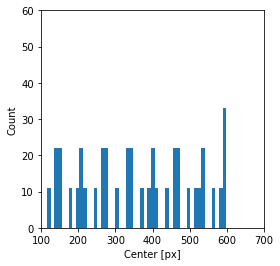

In [26]:
plt.figure(figsize=(4, 4))
plt.hist(centers, bins=50)
plt.xlabel("Center [px]")
plt.ylabel("Count")
plt.ylim(0, 60)
plt.xlim(100, 700)
plt.savefig("patch_center_distr_training.png")

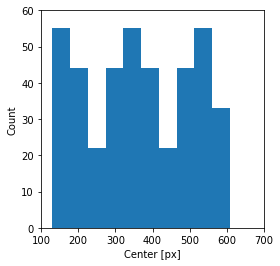

In [22]:
plt.figure(figsize=(4, 4))
plt.hist(centers)
plt.xlabel("Center [px]")
plt.ylabel("Count")
plt.ylim(0, 60)
plt.xlim(100, 700)
plt.savefig("patch_center_distr_training.png")

## test

In [3]:
idx = 9
pw = 496
img = np.array(Image.open(f"../../generated_corrected/training/DME_{pw}/img_{idx}.png"))
mask = np.array(Image.open(f"../../generated_corrected/training/DME_{pw}/mask_{idx}.png"))
fluid = np.array(Image.open(f"../../generated_corrected/training/DME_{pw}/fluid_{idx}.png"))
lyr = torch.load(f"../../generated_corrected/training/DME_{pw}/lyr_{idx}.pkl")

In [2]:
from utils.misc import get_loaders, get_loaders_retlstm

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [102]:
import random
torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [70]:
train_dl, valid_dl, mean_std = get_loaders_retlstm("../../corrected_ds", 496, 1, None, True, True, True)
train_it = iter(train_dl)
# fluid_g = ((img, (mask, fluid, lyr)) for (img, (mask, fluid, lyr)))

In [71]:
x, _, corners, _ = next(iter(valid_dl))

In [114]:
i = torch.randn(8)

In [117]:
j = torch.randn(16, 8, 4, 8)

In [119]:
i.expand_as(j).shape

torch.Size([16, 8, 4, 8])

In [105]:
img, (mask, fluid, lyr) = next(train_it)
show_layers_from_mask(img.squeeze(), mask.squeeze(), mean_std=mean_std).show()
# show_layers_from_boundary(img, lyr, fluid=fluid).show()

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [104]:
x, _ = next(iter(train_dl))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2fc4634200>
Traceback (most recent call last):
  File "/home/loerinczy/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/loerinczy/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/loerinczy/anaconda3/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2fc4634200>
Traceback (most recent call last):
  File "/home/loerinczy/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/loerinczy/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader

In [107]:
d, _ = next(iter(train_dl))

In [108]:
x.allclose(d)

False

In [19]:
from torch import nn
from relay_net.losses import DiceLoss
from misc import get_loaders, get_fluid_boundary
import torch.nn.functional as F

class CombinedLoss(nn.Module):

    def __init__(
              self,
              num_classes=9,
              weight_channel_cross=None,
              weight_channel_dice=None,
              weight_boundary_cross=1.
    ):
        super(CombinedLoss, self).__init__()
        self.cross_entropy_loss_fn = nn.CrossEntropyLoss()
        self.dice_loss_fn = DiceLoss(weight_channel_dice, num_classes)
        self.weight_channel_cross = (
            weight_channel_cross if weight_channel_cross is not None
            else torch.ones(num_classes)
        )
        self.weight_boundary_cross = weight_boundary_cross
        self.num_classes = num_classes

    def forward(self, predictions, targets):
        if self.num_classes == 10:
            targets, fluid = targets
            fluid_boundary = get_fluid_boundary(fluid)
        weight_boundary = F.pad(targets[:, 1:, :] - targets[:, :-1, :], (0, 0, 0, 1), "constant", 0)
        weight_boundary[weight_boundary != 1] = 0
        if self.num_classes == 10:
            weight_boundary = torch.logical_or(weight_boundary, fluid_boundary)
            targets[fluid.bool()] = 9
#         return weight_boundary
        wb = weight_boundary.clone()
        weight_boundary = weight_boundary * self.weight_boundary_cross
        weight_channel = torch.zeros(*targets.shape, self.num_classes, device=targets.device).scatter_(
                  -1, targets.unsqueeze(-1), 1
        )
        weight_channel = weight_channel * self.weight_channel_cross
        weight_channel = weight_channel.max(-1).values
        return weight_channel, wb
        weight = 1 + weight_boundary + weight_channel
        weight /= weight.sum()
        cross_entropy_loss = (self.cross_entropy_loss_fn(predictions, targets) * weight).sum()
        dice_loss = self.dice_loss_fn(predictions, targets)
        return cross_entropy_loss, dice_loss

In [94]:
loss = CombinedLoss(10, torch.tensor([0, 5, 5, 5, 5, 5, 5, 5, 0, 5]).float())

In [95]:
train_dl, valid_dl, mean_std = get_loaders("../../generated_corrected", True, 496, 1, None, 2)
train_it = iter(train_dl)

In [103]:
# x, (y, f, l) = next(train_it)
wc, wb = loss(x, (y.long(), f))
Image.fromarray(wc.squeeze().byte().numpy() * 40).show()
Image.fromarray(wb.squeeze().byte().numpy() * 255).show()

In [321]:
model = nn.Linear(3, 1, bias=False)
# model = nn.Sequential(
#     nn.Linear(3, 3, bias=False),
#     nn.ReLU(True),
#     nn.Linear(3, 1, bias=False),
# )
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [327]:
losses = []
preds = []
for epoch in range(200):
    for idx in range(20):
        r = torch.randint(2, 3, (100,))
        t = torch.zeros(100, 3)
        t.scatter_(-1, r.unsqueeze(1), 1)
#         t = t + 1e-3
        r = r.float()
        optimizer.zero_grad()
        pred = model(t.squeeze().float())
        preds += pred.flatten().tolist()
#         r = (r - r.mean()) / r.std()
#         pred = torch.tile(torch.tensor([0, 1, 2]), (100, 1)).float() @ t.T
        loss = loss_fn(pred, r.float())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

In [328]:
next(model.parameters())

Parameter containing:
tensor([[-1.2696e-04,  9.9952e-01,  1.9993e+00]], requires_grad=True)

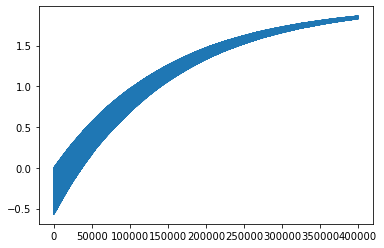

In [314]:
plt.plot(preds)

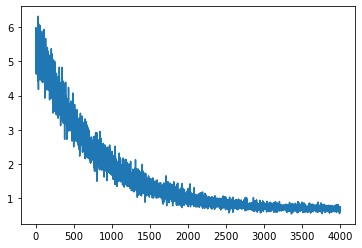

In [313]:
plt.plot(losses)

In [109]:
train_dl, valid_dl, mean_std = get_loaders_retlstm("../../generated_corrected", 64, 32, None, 2)
train_it = iter(train_dl)

In [110]:
for x, y in train_dl:
    if y.isnan().all():
        print("error")

In [14]:
x, y = next(train_it)
x = (x * mean_std[1] + mean_std[0]) * 255
y = (y * mean_std[3] + mean_std[2]) * 496
show_layers_from_boundary(x.T.byte(), y,).show()

In [17]:
a = np.random.randint(0, 10, (4, 4))

In [21]:
a[:, 0]

array([6, 0, 9, 9])

In [15]:
from metric import contour_error

In [37]:
np.where(np.isnan(y.numpy()))

(array([4, 4, 4, 4]), array([246, 247, 293, 294]))

In [139]:
data = loadmat("../../dataset/raw/6-10/Subject_06.mat")

In [140]:
lyr = data["manualLayers1"][..., 13]
img = data["images"][..., 13]

In [1312]:
mask = np.array(Image.open('corrected/1-5/0-30-mask.png'))
img = np.array(Image.open('corrected/1-5/0-30-img.png'))
ascans = np.where((mask != 0).any(0))[0]
for ascan_idx in ascans:
    ascan = mask[:, ascan_idx]
    notbase = np.where(ascan != 0)[0]
    ascan[notbase[-1] + 1:] = 8

In [1313]:
fluid = np.zeros_like(mask, dtype=int)
fluid[mask == 9] = 1

In [1314]:
# shifted = fluid[:, 1:] - fluid[:, :-1]
# x, y = np.where(shifted == -1)
# y = y - 1
# shifted[shifted != 1] = 0
# shifted[x, y] = 1
# mask1 = np.pad(shifted, ((0, 0), (1, 0)), "constant", constant_values=0)
# shifted = fluid[1:, :] - fluid[:-1, :]
# x, y = np.where(shifted == -1)
# x = x - 1
# shifted[shifted != 1] = 0
# shifted[x, y] = 1
# mask2 = np.pad(shifted, ((1, 0), (0, 0)), "constant", constant_values=0)
# mask = np.logical_or(mask1, mask2).astype(float)

In [1315]:
mask[mask == 9] = 100

In [1316]:
shifted = mask[1:, :] - mask[:-1, :]
mask = np.pad(shifted, ((1, 0), (0, 0)), "constant", constant_values=0)
mask[mask != 1] = 0

In [1317]:
Image.fromarray((mask * 254).astype("uint8")).show()

In [1208]:
Image.fromarray(fmask.squeeze().numpy() * 255).show()

In [1179]:
show_layers_from_mask(img, mask).show()

In [1190]:
idx = 3
img = np.array(Image.open(f"../../generated/training/DME_496/img_{idx}.png"))
mask = np.array(Image.open(f"../../generated/training/DME_496/mask_{idx}.png"))
fluid = np.array(Image.open(f"../../generated/training/DME_496/fluid_{idx}.png"))

In [1193]:
from utils.misc import get_fluid_boundary

In [1195]:
fmask = get_fluid_boundary(torch.from_numpy(fluid).unsqueeze(0))

# Plot boundary mask

In [2]:
from utils.misc import get_loaders, get_fluid_boundary
import torch.nn.functional as F

In [4]:
train_dl, valid_dl, mean_std = get_loaders("../../corrected_ds", True, 496, 1, None, 2)
fluid_g = ((x, (mask, fluid, layer)) for x, (mask, fluid, layer) in valid_dl if fluid.any().item())

ValueError: not enough values to unpack (expected 3, got 2)

In [66]:
# x, (y, f, l) = next(fluid_g)
# xc = x.clone()
yf = y.clone()
yf[f.bool()] = 9
# x = xc[:, 80:300]
y = y.int()
# show_layers_from_mask(x.squeeze(), torch.zeros_like(x.squeeze()), mean_std).convert(mode="RGB").show()#.save("cover.png")
boundary = F.pad(y[:, 1:, :] - y[:, :-1, :], (0, 0, 0, 1), "constant", 0)
boundary[boundary != 1 ] = 0
fmask = get_fluid_boundary(f)
bf = torch.logical_or(boundary, fmask)
# Image.fromarray(boundary.byte().squeeze().numpy() * 255).convert(mode="RGB").show()#.save("mask.png")
# Image.fromarray(fmask.byte().squeeze().numpy() * 255).convert(mode="RGB").show()#.save("mask.png")
# Image.fromarray(bf.byte().squeeze().numpy() * 255).convert(mode="RGB").show()#.save("mask.png")
fluid = fmask.squeeze().numpy()
orig_img = ((x.squeeze() * mean_std[1] + mean_std[0]) * 255).clip(0).numpy()

img2 = Image.fromarray(
    np.array([
        np.ones_like(fluid, dtype="uint8") * 150,
        np.ones_like(fluid, dtype="uint8") * 0,
        np.ones_like(fluid, dtype="uint8") * 255]).transpose((1, 2, 0)), mode="HSV")

img = Image.fromarray(np.array([
    np.zeros_like(orig_img).astype("uint8"),
    np.zeros_like(orig_img).astype("uint8"),
    orig_img.astype("uint8"),]).transpose((1, 2, 0)), mode="HSV")

Image.composite(img2, img, Image.fromarray(fluid.astype("uint8") * 255)).convert(mode="RGB").show()#.save("raw-image-with-boundary.png")
img.show()
# Image.fromarray(img2.astype("uint8") * 255).show()

In [41]:
fluid = fmask.squeeze().numpy()
orig_img = ((x.squeeze() * mean_std[1] + mean_std[0]) * 255).clip(0).numpy()

img2 = Image.fromarray(
    np.array([
        np.ones_like(fluid, dtype="uint8") * 150,
        np.ones_like(fluid, dtype="uint8") * 0,
        np.ones_like(fluid, dtype="uint8") * 255]).transpose((1, 2, 0)), mode="HSV")

img = Image.fromarray(np.array([
    np.zeros_like(orig_img).astype("uint8"),
    np.zeros_like(orig_img).astype("uint8"),
    orig_img.astype("uint8"),]).transpose((1, 2, 0)), mode="HSV")

Image.composite(img2, img, Image.fromarray(fluid.astype("uint8") * 255)).convert(mode="RGB").show()#.save("raw-image-with-boundary.png")
img.show()
# Image.fromarray(img2.astype("uint8") * 255).show()

## Add fluid boundary weighting

In [242]:
# numpy version

shifted = fluid[:, 1:] - fluid[:, :-1]
x, y = np.where(shifted == -1)
y = y - 1
shifted[shifted != 1] = 0
shifted[x, y] = -1
shifted[shifted != 0] = 1
mask1 = np.pad(shifted, ((0, 0), (1, 0)), "constant", constant_values=0)
shifted = fluid[1:, :] - fluid[:-1, :]
x, y = np.where(shifted == -1)
x = x - 1
shifted[shifted != 1] = 0
shifted[x, y] = -1
shifted[shifted != 0] = 1
mask2 = np.pad(shifted, ((1, 0), (0, 0)), "constant", constant_values=0)
mask = np.logical_or(mask1, mask2).astype(float)


# torch version
shifted = f[:, 1:] - f[:, :-1]
x, y = torch.where(shifted == -1)
y = y - 1
shifted[shifted != 1] = 0
shifted[x, y] = 1
mask1 = torch.nn.functional.pad(shifted, (1, 0, 0, 0), "constant", 0)
shifted = f[1:, :] - f[:-1, :]
x, y = torch.where(shifted == -1)
x = x - 1
shifted[shifted != 1] = 0
shifted[x, y] = 1
mask2 = torch.nn.functional.pad(shifted, (0, 0, 1, 0), "constant", 0)
mask = torch.logical_or(mask1, mask2).int()

In [1184]:
idx = 3
img = np.array(Image.open(f"../../generated/training/DME_496/img_{idx}.png"))
lyr = np.array(Image.open(f"../../generated/training/DME_496/mask_{idx}.png"))
fluid = np.array(Image.open(f"../../generated/training/DME_496/fluid_{idx}.png"))

## Colorcoding

In [8]:
img_zero = np.zeros_like(img)
lyr_zero = np.zeros_like(lyr)

for i in range(1, 8):
    lyr_zero[(i-1) * 62:i * 62] = i
lyr_zero[496-62:496] = 9

show_layers_from_mask(img_zero, lyr_zero).convert(mode="RGB").save("colorcoding.png")

## Consensus between experts

In [22]:
train_dl, valid_dl, _ = get_loaders("../../generated", True, 64, 32, None, 2)

In [23]:
from utils.metric import Metric, dice_acc

In [24]:
dice = Metric(0, 9)
for x, (y, f) in valid_dl:

### Compute segmented length

In [320]:
data = loadmat("../../dataset/raw/2015_BOE_Chiu/Subject_02.mat")

In [321]:
idx = 28

In [322]:
img = data["images"][..., idx]
lyr = data["manualLayers1"][..., idx]

In [323]:
show_layers_from_boundary_array(img, lyr.T).show()

In [65]:
segmented_length = list()

for d in range(10):
    data = loadmat(dme[d])
    for lyr_ind in range(61):
        m1 = data["manualLayers1"][..., lyr_ind]
        m2 = data["manualLayers2"][..., lyr_ind]
        lengths = [] 
        if (~np.isnan(m1)).any():
            w_idx = np.where(~np.isnan(m1))[1]
            delta = w_idx[-1] - w_idx[0]
            lengths.append(delta)
        else:
            lengths.append(0)
        if (~np.isnan(m2)).any():
            w_idx = np.where(~np.isnan(m2))[1]
            delta = w_idx[-1] - w_idx[0]
            lengths.append(delta)
        else:
            lengths.append(0)
        if sum(lengths):
            segmented_length.append(tuple(lengths))
            
Counter(segmented_length)

Counter({(523, 523): 33,
         (547, 547): 11,
         (535, 535): 11,
         (541, 541): 33,
         (505, 505): 11,
         (499, 499): 11})

In [5]:
dme496img = sorted(list(Path("../../generated/DME_496/").glob("img*")))
dme496mask = sorted(list(Path("../../generated/DME_496").glob("mask*")))

In [6]:
img = np.array(Image.open(dme496img[0]))
mask = np.array(Image.open(dme496mask[0]))

In [8]:
show_layers_from_mask_array(img, mask).show()

# Generating the dataset

In [9]:
mid_list = []

In [10]:
patch_width = 64
# generate_dme_dataset("../../dataset/raw/1-5", f"../../generated/training/DME_{patch_width}", patch_width)
# generate_dme_dataset("../../dataset/raw/6-10", f"../../generated/validation/DME_{patch_width}", patch_width)
# len(list(Path(f"../../generated/training/DME_{patch_width}").glob("img*")))

data generation: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


In [11]:
# save
with open("validation_patch_center_64.pkl", "wb") as file:
    pickle.dump(mid_list, file)

In [18]:
# load
with open("training_patch_center_64.pkl", "rb") as file:
    mid_list = pickle.load(file)

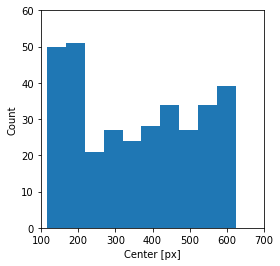

In [19]:
plt.figure(figsize=(4, 4))
plt.hist(mid_list)
plt.xlabel("Center [px]")
plt.ylabel("Count")
plt.ylim(0, 60)
plt.xlim(100, 700)
plt.savefig("patch_center_distr_training.png")

In [29]:
(.99 + .83 + .86 + .77 + .75 + .91 + .89 + .84 + 1) / 9

0.871111111111111

# Proove that the layer mask generation is correct

In [149]:
bmask = create_boundary_mask(lyr[:, 500:600], 496)
lmask = create_layer_mask(lyr[:, 500:600], 496)
diff = np.diff(lmask, axis=0)
(np.pad(diff, ((0, 1), (0, 0)), constant_values=(0,)) != bmask).sum()

0

# AMD

In [10]:
data = loadmat(amd[0])
idx = 30
img = data["images"][:, :, idx]
lyr = data["layerMaps"][idx]

In [14]:
def generate_amd_dataset(amd_dir, control_dir, output_dir, patch_width):
    files = list(
        chain(
            Path(amd_dir).glob("*"),
            Path(control_dir).glob("*")
        )
    )
    output_dir = Path(output_dir)
    output_dir.mkdir()
    cnt = 0
    for file in tqdm(files, desc="data generation"):
        data = loadmat(file)
        layers = data["layerMaps"].transpose((0, 2, 1))
        images = data["images"].transpose((2, 0, 1))
        for idx, (image, layer) in enumerate(zip(images, layers)):
            patch_generator = create_patches(image, layer, patch_width)
            for img, mask in patch_generator:
                Image.fromarray(img).save(output_dir / f"img_{cnt}.png")
                Image.fromarray(mask).save(output_dir / f"mask_{cnt}.png")
                cnt += 1

In [34]:
patch_width = 736
generate_amd_dataset(
    "../../dataset/raw/AMD/",
    "../../dataset/raw/Control/",
    f"../../generated/AMD_{patch_width}",
    patch_width
)

data generation: 100%|██████████| 384/384 [04:31<00:00,  1.42it/s]


In [35]:
len(list(Path("../../generated/AMD_736").glob("img*")))

2901

In [26]:
mod = nn.Sequ

784

In [33]:
736 / 16

46.0

In [11]:
show_layers_from_boundary_array(img, lyr).show()
show_boundary_from_boundary_array(img, lyr).show()